# TV Script Generation

In this project, you'll generate your own [Seinfeld](https://en.wikipedia.org/wiki/Seinfeld) TV scripts using RNNs.  You'll be using part of the [Seinfeld dataset](https://www.kaggle.com/thec03u5/seinfeld-chronicles#scripts.csv) of scripts from 9 seasons.  The Neural Network you'll build will generate a new ,"fake" TV script, based on patterns it recognizes in this training data.

## Get the Data

The data is already provided for you in `./data/Seinfeld_Scripts.txt` and you're encouraged to open that file and look at the text. 
>* As a first step, we'll load in this data and look at some samples. 
* Then, you'll be tasked with defining and training an RNN to generate a new script!

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# load in data
import helper
data_dir = './data/Seinfeld_Scripts.txt'
text = helper.load_data(data_dir)

## Explore the Data
Play around with `view_line_range` to view different parts of the data. This will give you a sense of the data you'll be working with. You can see, for example, that it is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [2]:
view_line_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))

lines = text.split('\n')
print('Number of lines: {}'.format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print('Average number of words in each line: {}'.format(np.average(word_count_line)))

print()
print('The lines {} to {}:'.format(*view_line_range))
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))

Dataset Stats
Roughly the number of unique words: 46367
Number of lines: 109233
Average number of words in each line: 5.544240293684143

The lines 0 to 10:
jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! y

---
## Implement Pre-processing Functions
The first thing to do to any dataset is pre-processing.  Implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following **tuple** `(vocab_to_int, int_to_vocab)`

In [3]:
import problem_unittests as tests
from string import punctuation

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    vocab_to_int = {}
    int_to_vocab = {}
    # get rid of punctuation
    for idx, word in enumerate(set(text)):
        vocab_to_int[word] = idx+1
        int_to_vocab[idx+1] = word
    
    # return tuple
    return (vocab_to_int, int_to_vocab)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_create_lookup_tables(create_lookup_tables)

Tests Passed


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks can create multiple ids for the same word. For example, "bye" and "bye!" would generate two different word ids.

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parentheses ( **(** )
- Right Parentheses ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it.  This separates each symbols as its own word, making it easier for the neural network to predict the next word. Make sure you don't use a value that could be confused as a word; for example, instead of using the value "dash", try using something like "||dash||".

In [4]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
from string import punctuation
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    return {
        '.': '||period||',
        ',': '||comma||',
        '"': '||quotationmark||',
        ';': '||semicolon||',
        '!': '||exclamation_mark||',
        '?': '||question_mark||',
        '(': '||left_parentheses||',
        ')': '||right_parentheses||',
        '-': '||dash||',
        '\n': '||return||'
    }

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_tokenize(token_lookup)

Tests Passed


## Pre-process all the data and save it

Running the code cell below will pre-process all the data and save it to file. You're encouraged to lok at the code for `preprocess_and_save_data` in the `helpers.py` file to see what it's doing in detail, but you do not need to change this code.

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# pre-process training data
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

## Build the Neural Network
In this section, you'll build the components necessary to build an RNN by implementing the RNN Module and forward and backpropagation functions.

### Check Access to GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

## Use a negative sampling approach to generate an embedding layer
### We use a higher threshold, to avoid reducing the data too much

In [53]:
from collections import Counter
import random
embedding_dim = 300

threshold = 1e-2
word_counts = Counter(int_text)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_text)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_text if random.random() < (1 - p_drop[word])]

In [54]:
len(int_text)

892110

In [55]:
len(train_words)

709318

In [56]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [57]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [58]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [59]:
import torch
from torch import nn
import torch.optim as optim

In [60]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
        
    def forward_input(self, input_words):
        # return input vector embeddings
        return self.in_embed(input_words)
    
    def forward_output(self, output_words):
        # return output vector embeddings
        return self.out_embed(output_words)
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if model.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        
        ## get the noise embeddings
        # reshape the embeddings so that they have dims (batch_size, n_samples, n_embed)
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)

        
        return noise_vectors

In [61]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # negate and sum correct and noisy log-sigmoid losses
        # return average batch loss
        return -(out_loss + noise_loss).mean()

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
model = SkipGramNeg(len(vocab_to_int)+1, embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1000
steps = 0
epochs = 30
window_size = 8
# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512, window_size=window_size):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, outpt, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], window_size)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                if valid_idx.item() != 0:
                    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                    print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/30
Loss:  1.62925124168396
dubious | menu, knicks, nedda, ahhh, godfather
concentrate | exhibit, remotely, semper, tears, we'd
reaching | moves, whoaaaa, black, kickin', fred:
indeterminate | dick's, yesterday, untimely, karen, visaki:
un | rachel, sum'in, train, nudges, carrying
magoo | moron, gestapo, loungingly, voyage, creep
lick | virgins, microphone, 103, live, instinct
disconnected | triangle, benefits, underpants, anxious, competitive
roosters | falsified, beckoning, grubby, cooler, hardwood
depressed | tomei, dude's, rushes, taps, highlighter
julie | couch, or, fudge, something, mouth
ecstatic | bought, bricker, surprises, clothes, forcing
force | all, needed, squeeze, xl, lippman:
ih | [hangs, goosebumps, cleavage, precendent, owow
we've | thirty, new, didn't, dawn, damn
jobs | jorge, beauty, neatness, sir, strange
...

Epoch: 2/30
Loss:  1.340833306312561
cross | beauty, sweatpants, chef, cookie, khan
malaise | spaghetti, destroy, joined, tantric, repulsive
disturbe

## Ignore the first embedding, which causes us to need an offset of 1 for int to vocab

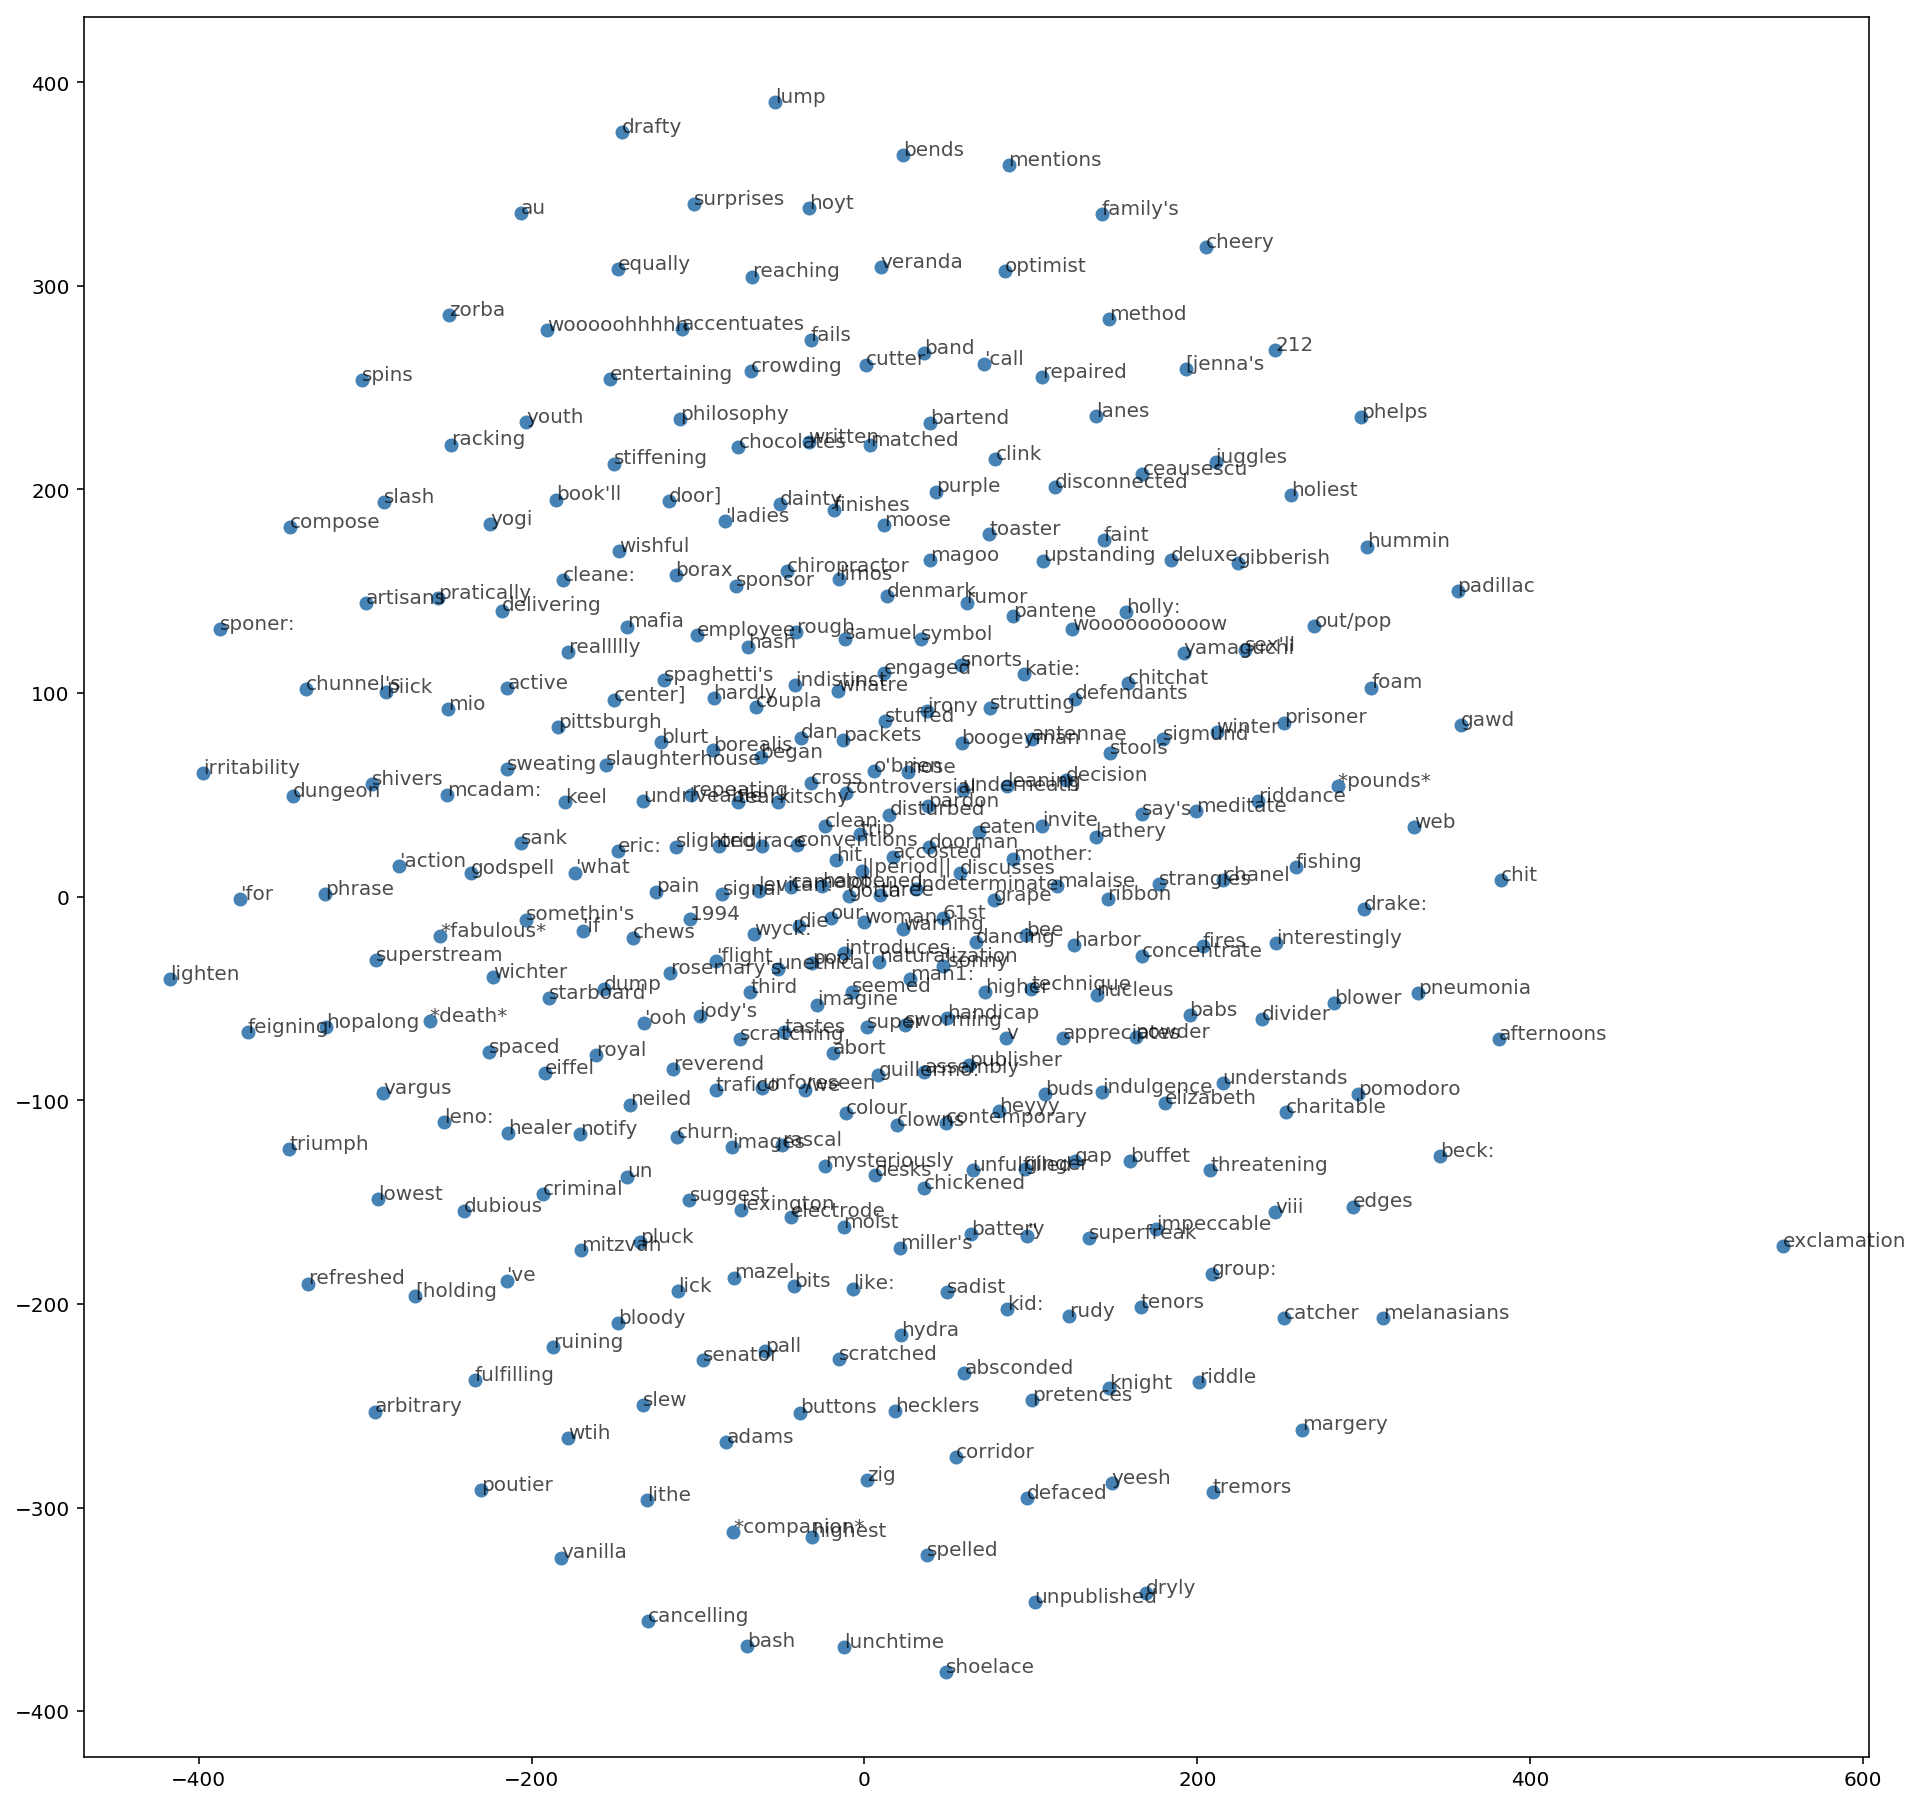

In [77]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()
viz_words = 340
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[1:viz_words+1, :])
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx+1], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

## Input
Let's start with the preprocessed input data. We'll use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

You can create data with TensorDataset by passing in feature and target tensors. Then create a DataLoader as usual.
```
data = TensorDataset(feature_tensors, target_tensors)
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=batch_size)
```

### Batching
Implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

>You can batch words using the DataLoader, but it will be up to you to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Your first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```
And the corresponding `target_tensor` should just be the next "word"/tokenized word value:
```
5
```
This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

In [78]:
from torch.utils.data import TensorDataset, DataLoader

def batch_data(words, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the TV scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # Get the number of batches as an integer 
    num_batches = len(words) // batch_size
    # Trim words so it can is only full batches
    words = words[:num_batches * batch_size]
    
    x = []
    y = []
    for index in range(0, len(words) - sequence_length):
        x.append(words[index:index + sequence_length])
        y.append(words[index + sequence_length])
    
    # Create tensors
    x = torch.from_numpy(np.array(x))
    y = torch.from_numpy(np.array(y))
    
    #Tensor Data Set
    ds = TensorDataset(x, y)
    
    #Data Loader
    data_loader = torch.utils.data.DataLoader(ds, shuffle=False, batch_size=batch_size)
    # return a dataloader
    return data_loader

# there is no test for this function, but you are encouraged to create
# print statements and tests of your own
dl = batch_data([0,1,2,2,3,3,4,54,5,10],sequence_length=4,batch_size=2)
for i in next(iter(dl)):
    print(i.size())
    print(i)

torch.Size([2, 4])
tensor([[ 0,  1,  2,  2],
        [ 1,  2,  2,  3]])
torch.Size([2])
tensor([ 3,  3])


### Test your dataloader 

You'll have to modify this code to test a batching function, but it should look fairly similar.

Below, we're generating some test text data and defining a dataloader using the function you defined, above. Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Your code should return something like the following (likely in a different order, if you shuffled your data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

### Sizes
Your sample_x should be of size `(batch_size, sequence_length)` or (10, 5) in this case and sample_y should just have one dimension: batch_size (10). 

### Values

You should also notice that the targets, sample_y, are the *next* value in the ordered test_text data. So, for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

In [79]:
# test dataloader

test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[  0,   1,   2,   3,   4],
        [  1,   2,   3,   4,   5],
        [  2,   3,   4,   5,   6],
        [  3,   4,   5,   6,   7],
        [  4,   5,   6,   7,   8],
        [  5,   6,   7,   8,   9],
        [  6,   7,   8,   9,  10],
        [  7,   8,   9,  10,  11],
        [  8,   9,  10,  11,  12],
        [  9,  10,  11,  12,  13]])

torch.Size([10])
tensor([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14])


---
## Build the Neural Network
Implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). You may choose to use a GRU or an LSTM. To complete the RNN, you'll have to implement the following functions for the class:
 - `__init__` - The initialize function. 
 - `init_hidden` - The initialization function for an LSTM/GRU hidden state
 - `forward` - Forward propagation function.
 
The initialize function should create the layers of the neural network and save them to the class. The forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

**The output of this model should be the *last* batch of word scores** after a complete sequence has been processed. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

### Hints

1. Make sure to stack the outputs of the lstm to pass to your fully-connected layer, you can do this with `lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)`
2. You can get the last batch of word scores by shaping the output of the final, fully-connected layer like so:

```
# reshape into (batch_size, seq_length, output_size)
output = output.view(batch_size, -1, self.output_size)
# get last batch
out = output[:, -1]
```

In [81]:
import torch.nn as nn
import torch.nn.functional as F
class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, embedding_pretrained=None, dropout=0.5):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()        
        # set class variables
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_size = output_size
        
        # define model layers
        
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        if embedding_pretrained is not None:
            self.embed.weight.data.copy_(embedding_pretrained.weight.data)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(0.17)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        :param nn_input: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """
        batch_size = nn_input.size(0)
        x = self.embed(nn_input)
        lstm_out, hidden = self.lstm(x, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        lstm_out = self.dropout(lstm_out)
        fc_out = self.fc(lstm_out)#F.softmax(self.fc(lstm_out), dim=1)
        
        #Reshape batch first
        fc_out = fc_out.view(batch_size, -1, self.output_size)
        # Get last batch of labels
        fc_out = fc_out[:, -1]
        # return one batch of output word scores and the hidden state
        return fc_out, hidden
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        
        # initialize hidden state with zero weights, and move to GPU if available
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_rnn(RNN, train_on_gpu)

Tests Passed


### Define forward and backpropagation

Use the RNN class you implemented to apply forward and back propagation. This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)`. Recall that you can get this loss by computing it, as usual, and calling `loss.item()`.

**If a GPU is available, you should move your data to that GPU device, here.**

In [82]:
def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param decoder: The PyTorch Module that holds the neural network
    :param decoder_optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    
    # move data to GPU, if available
    #inp, target = torch.LongTensor(inp), torch.LongTensor(target)
    if train_on_gpu:
        inp, target = inp.cuda(), target.cuda()
    hidden = tuple([each.data for each in hidden])
    
    # perform backpropagation and optimization
    rnn.zero_grad()
    probs, hidden = rnn(inp, hidden)
    loss = criterion(probs, target)
    
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(rnn.parameters(), 5)
    
    optimizer.step()

    # return the loss over a batch and the hidden state produced by our model
    return loss.item(), hidden

# Note that these tests aren't completely extensive.
# they are here to act as general checks on the expected outputs of your functions
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_forward_back_prop(RNN, forward_back_prop, train_on_gpu)

Tests Passed


## Neural Network Training

With the structure of the network complete and data ready to be fed in the neural network, it's time to train it.

### Train Loop

The training loop is implemented for you in the `train_decoder` function. This function will train the network over all the batches for the number of epochs given. The model progress will be shown every number of batches. This number is set with the `show_every_n_batches` parameter. You'll set this parameter along with other parameters in the next section.

In [83]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(
                    epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses = []

    # returns a trained rnn
    return rnn

### Hyperparameters

Set and train the neural network with the following parameters:
- Set `sequence_length` to the length of a sequence.
- Set `batch_size` to the batch size.
- Set `num_epochs` to the number of epochs to train for.
- Set `learning_rate` to the learning rate for an Adam optimizer.
- Set `vocab_size` to the number of uniqe tokens in our vocabulary.
- Set `output_size` to the desired size of the output.
- Set `embedding_dim` to the embedding dimension; smaller than the vocab_size.
- Set `hidden_dim` to the hidden dimension of your RNN.
- Set `n_layers` to the number of layers/cells in your RNN.
- Set `show_every_n_batches` to the number of batches at which the neural network should print progress.

If the network isn't getting the desired results, tweak these parameters and/or the layers in the `RNN` class.

In [84]:
# Data params
# Sequence Length
sequence_length = 50 # of words in a sequence
# Batch Size
batch_size = 256

# data loader - do not change
train_loader = batch_data(int_text, sequence_length, batch_size)

In [85]:
len(train_loader)

3484

In [86]:
# Training parameters
# Number of Epochs
num_epochs = 10
# Learning Rate
learning_rate = 0.001

# Model parameters
# Vocab size
vocab_size = len(vocab_to_int) + 1
# Output size
output_size = vocab_size
# Embedding Dimension
embedding_dim = embedding_dim
# Hidden Dimension
hidden_dim = 256
# Number of RNN Layers
n_layers = 3

# Show stats for every n number of batches
show_every_n_batches = 3000

### Train
In the next cell, you'll train the neural network on the pre-processed data.  If you have a hard time getting a good loss, you may consider changing your hyperparameters. In general, you may get better results with larger hidden and n_layer dimensions, but larger models take a longer time to train. 
> **You should aim for a loss less than 3.5.** 

You should also experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

## We'll give our model a pretrained embedding, and freeze the weights on it, to make training go faster.

In [102]:
pretrained_embed = model.in_embed
fine_tune_embed = True

In [103]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from workspace_utils import active_session

if pretrained_embed is not None:
    if not fine_tune_embed:
        for param in rnn.embed.parameters():
            param.requires_grad = False

# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, embedding_pretrained=pretrained_embed, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

parameters = filter(lambda p: p.requires_grad, rnn.parameters())
# defining loss and optimization functions for training
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

criterion = nn.CrossEntropyLoss()


with active_session():
    # training the model
    trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnnPretrained_embed', trained_rnn)
print('Model Trained and Saved')

Training for 10 epoch(s)...
Epoch:    1/10    Loss: 5.383437935670217

Epoch:    2/10    Loss: 4.373893511421955

Epoch:    3/10    Loss: 4.076367495767077

Epoch:    4/10    Loss: 3.9071297343695193

Epoch:    5/10    Loss: 3.78487287524648

Epoch:    6/10    Loss: 3.695829314402455

Epoch:    7/10    Loss: 3.6214011714884924

Epoch:    8/10    Loss: 3.563625251223498

Epoch:    9/10    Loss: 3.507609050779756

Epoch:   10/10    Loss: 3.4629430693523178



/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model Trained and Saved


### Question: How did you decide on your model hyperparameters? 
For example, did you try different sequence_lengths and find that one size made the model converge faster? What about your hidden_dim and n_layers; how did you decide on those?

**Answer:** 

N_Layers:
I used the rule of thumb provided in the videos, that more than 1 layer generally performs better.  Then followed what I saw with the RNN Sentiment prediction task, where I saw that 3 worked well.

Hidden Dim:
I Tried to pick something that would be large enough to handle the context that we were providing to the model.  Again, we had seen with the same embedding size on the sentiment task, that 256 worked well, with an embeddign dimension of 200.

Sequence Length:
I picked one that was larger than an average sentence, the thought here was that, we want to model to be able to take concepts from early in a sequence, and utilize them when it is writing text.  This was the reasoning for picking a number of 50.

---
# Checkpoint

After running the above training cell, your model will be saved by name, `trained_rnn`, and if you save your notebook progress, **you can pause here and come back to this code at another time**. You can resume your progress by running the next cell, which will load in our word:id dictionaries _and_ load in your saved model by name!

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./save/trained_rnnPretrained_embed')

## Generate TV Script
With the network trained and saved, you'll use it to generate a new, "fake" Seinfeld TV script in this section.

### Generate Text
To generate the text, the network needs to start with a single word and repeat its predictions until it reaches a set length. You'll be using the `generate` function to do this. It takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses topk sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [105]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import torch.nn.functional as F

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    :param decoder: The PyTorch Module that holds the trained neural network
    :param prime_id: The word id to start the first prediction
    :param int_to_vocab: Dict of word id keys to word values
    :param token_dict: Dict of puncuation tokens keys to puncuation values
    :param pad_value: The value used to pad a sequence
    :param predict_len: The length of text to generate
    :return: The generated text
    """
    rnn.eval()
    
    # create a sequence (batch_size=1) with the prime_id
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get the next word probabilities
        p = F.softmax(output, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
         
        # use top_k sampling to get the index of the next word
        top_k = 5
        p, top_i = p.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())
        
        # retrieve that word from the dictionary
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        # the generated word becomes the next "current sequence" and the cycle can continue
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # return all the sentences
    return gen_sentences

### Generate a New Script
It's time to generate the text. Set `gen_length` to the length of TV script you want to generate and set `prime_word` to one of the following to start the prediction:
- "jerry"
- "elaine"
- "george"
- "kramer"

You can set the prime word to _any word_ in our dictionary, but it's best to start with a name for generating a TV script. (You can also start with any other names you find in the original text file!)

In [106]:
# run the cell multiple times to get different results!
gen_length = 8000 # modify the length to your preference
prime_word = 'jerry' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


jerry: he was...

jerry: what do they mean?

george: yes, it's a new long relationship to see you. i can't get out of my life.

george: well, you should have seen this guy.

jerry: what is it?

hoyt: i can't tell me.

vandelay:(to jerry) oh, you know what?

hoyt: yes, you know, we could go down to a plane, i think we were a little little... and you know, i'm not going to be a lot.

george:(sarcastic) what do you mean about the rest?

george: i thought you were in a wheelchair with the lipo. you know, i think it's a good time, and you have to see the rest of a cab and you know.

george: well i don't know what i think that i can have to see the other.

george: i can't go to the bathroom.

chiles:(pointing at the table) hey, hey, wait a second!

hoyt: i got to call it to the bathroom.

vandelay: so, the prosecution said that you are going to be a little favor.

george: i can't see that.

george: what is this?

hoyt: i can't go to the hospital, and it is the accident!

hoyt: what is this?!

#### Save your favorite scripts

Once you have a script that you like (or find interesting), save it to a text file!

In [107]:
# save script to a text file
f =  open("generated_script_2_pretrained_embed.txt","w")
f.write(generated_script)
f.close()

# The TV Script is Not Perfect
It's ok if the TV script doesn't make perfect sense. It should look like alternating lines of dialogue, here is one such example of a few generated lines.

### Example generated script

>jerry: what about me?
>
>jerry: i don't have to wait.
>
>kramer:(to the sales table)
>
>elaine:(to jerry) hey, look at this, i'm a good doctor.
>
>newman:(to elaine) you think i have no idea of this...
>
>elaine: oh, you better take the phone, and he was a little nervous.
>
>kramer:(to the phone) hey, hey, jerry, i don't want to be a little bit.(to kramer and jerry) you can't.
>
>jerry: oh, yeah. i don't even know, i know.
>
>jerry:(to the phone) oh, i know.
>
>kramer:(laughing) you know...(to jerry) you don't know.

You can see that there are multiple characters that say (somewhat) complete sentences, but it doesn't have to be perfect! It takes quite a while to get good results, and often, you'll have to use a smaller vocabulary (and discard uncommon words), or get more data.  The Seinfeld dataset is about 3.4 MB, which is big enough for our purposes; for script generation you'll want more than 1 MB of text, generally. 

# Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_tv_script_generation.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "helper.py" and "problem_unittests.py" files in your submission. Once you download these files, compress them into one zip file for submission.

## Check out embeddings if they were trained with the RNN

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
if  fine_tune_embed:
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    # getting embeddings from the embedding layer of our model, by name
    embeddings = trained_rnn.in_embed.weight.to('cpu').data.numpy()
    viz_words = 340
    tsne = TSNE()
    embed_tsne = tsne.fit_transform(embeddings[1:viz_words+1, :])
    fig, ax = plt.subplots(figsize=(16, 16))
    for idx in range(viz_words):
        plt.scatter(*embed_tsne[idx, :], color='steelblue')
        plt.annotate(int_to_vocab[idx+1], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)